# 2023年度报告-收入分析

使用em的业绩报告数据。

In [1]:
import pandas as pd
from scipy.stats import zscore
import akshare as ak
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
# import altair as alt
import numpy as np
from IPython.display import HTML
import sqlite3
from pathlib import Path
import datetime
from uuid import uuid4


In [2]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

In [3]:
# def begin with plot, always use widedf
# def begin with draw, always use other df

def showProfile(df) :
    col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
    col_profile.columns = ['列名', '类型', '缺失比%','样例']
    return (col_profile)

def fold_dataframe(df, n):
    # 确保 n 是正整数
    if n <= 0:
        raise ValueError("n 必须是正整数")
    # 添加一个新列，用于标记每一行的段号
    df = df.copy()
    m = len(df.columns)
    grey_list = [i for i in range(m, m*n+1, m+1)]
    df['id'] = [(i % n) for i in range(len(df))]
    # 使用groupby分成n组
    grouped = df.groupby('id')
    # 将每组取出来重设索引和列名
    segments = []
    for l, g in grouped:
        g = g.reset_index(drop=True)
        # 设置列格式时不支持重名的列，所以先把每组列名修改为不同
        g.columns =[f'{c}_{l}' for c in g.columns]
        segments.append(g)
    
    # 横向拼接起来
    folded_df = pd.concat(segments, axis=1)
    # folded_df = folded_df.astype('str')
    folded_df = folded_df.drop(columns=folded_df.columns[-1])
    folded_df = folded_df.replace(np.nan, '')
    # folded_df.iloc[:,grey_list] = folded_df.iloc[:,grey_list].astype('str') # 新建的列做为每组之间的分隔列
    # folded_df.iloc[:,grey_list] = ''
    def apply_color_by_position(df, cols_to_highlight):  
        '''  
        根据列位置为特定列设置红色背景色。  
        cols_to_highlight 是一个包含要设置样式的列位置的列表（从0开始计数）。  
        '''  
        # 创建一个空的DataFrame来存储样式  
        style_df = pd.DataFrame('', index=df.index, columns=df.columns)
        # 遍历要设置样式的列位置  
        for col_pos in cols_to_highlight:  
            # 注意：DataFrame.columns 返回一个Index对象，我们可以使用.iloc或.get_loc来获取位置对应的列名  
            col_name = df.columns[col_pos]  
            # 为该列的所有单元格设置背景色  
            style_df.loc[:, col_name] = 'background-color: grey; color: grey;'
        return style_df  
  
    # 调用函数并设置第2列和第3列（位置索引为1和2）的背景色为红色  
    folded_df = (folded_df.style
                 .format(precision=2)
                 .apply(apply_color_by_position, cols_to_highlight=grey_list, axis=None)
                 .relabel_index([i.split('_')[0] for i in folded_df.columns], axis=1)
                 .hide())  
    return folded_df

def plot_barh(df, title=None, fmt=''):
    # fmt = lambda x: f'{x:.2f}'
    height = len(df)*25/72+0.5
    ax = df.plot.barh(figsize=(10, height), width=0.8, legend=False, zorder=3)
    ax.bar_label(ax.containers[0], label_type='edge', fmt=fmt)
    ax.xaxis.tick_top()
    # ax.xaxis.grid(True, color='#EEEEEE', zorder=0)
    # ax.tick_params(left=False, bottom=False, top=False, right=False)
    title = title if title else df.columns[0]
    ax.set_title(title, fontsize=16, pad=20)
    
    plt.show(ax)

def plot_line(df, title=''):
    ax = df.plot.line(figsize=(10, 5), title=title)
    ax.tick_params(left=False, bottom=False)
    ax.yaxis.grid(True, color = '#EEEEEE')
    return plt.show(ax)

def df_cards(df, cols=None):
    """
    把df的每一行转化为html卡片形式。
    df: 整理好的DataFrame
    cols: 要展示的列名列表，需要在调用前进行修改。确定需要展示的样式：title, big, item, content等， 如果不提供，默认使用df的列名。
    """
    if not cols:
        cols = df.columns
    df.columns = [i for i in range(len(df.columns))]
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('cards.html')
    html_out = template.render(cols=cols, df=df)

    return HTML(html_out)

def plot_desc(df:pd.DataFrame):
    """
    x is time axis
    """
    df = df.T
    df = pd.concat([df.mean(), df.median(), df.max(), df.min()], axis=1)
    df.columns = ['mean', 'median', 'max', 'min']
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    df.iloc[:,[0,1]].plot(kind='line', ax=axs[0])
    df.iloc[:,[2,3]].plot(kind='line', ax=axs[1])
    plt.tight_layout()
    plt.show()

def plot_labs(df: pd.DataFrame, oneline:bool = False):
    """
    将df输出为包含三个值title, value, rank的标签。
    df: 二列或者三列，第一列为cname, 第二列为值，第三列可为其它数，如果没有第三列，则创建第三列为rank
    """
    uid = uuid4()
    if len(df.columns) == 2:
        df = df.reset_index(drop=True)
        df['rank'] = df.index+1
    codes = pd.read_csv('codes.csv', dtype={'code':'str'})[['cname', 'code']]
    df = df.merge(codes, on='cname')
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('lab.html')
    html_out = template.render(df=df, oneline = oneline, uid = uid)
    return HTML(html_out)

def plot_subs(df:pd.DataFrame, cols:int, kind:str = 'barh'):
    """
    plot subplot.
    df: must be tidied, keep only data cols
    cols: how many columns in the subplots
    """
    s = df.shape
    rows = int(s[1]/cols)+1
    lay = (rows, cols)
    height = s[0]*0.3*rows
    axs = df.plot(kind=kind, subplots=True, layout=lay, figsize=(10,height), sharex=True, sharey=True, fontsize=8, legend=False)
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def plot_muti_lines(df: pd.DataFrame):
    """
    multiline chart
    legend order by last column, and in left side.
    """
    height = max(0.3*len(df.T), 5)
    ax = df.plot.line(figsize=(10, height))
    handles, labels = ax.get_legend_handles_labels()
    # h = list(df.iloc[-1].sort_values(ascending=False).index.values)
    ol = list(df.iloc[-1].sort_values(ascending=False).index.values)
    oh = [handles[labels.index(label)] for label in ol]
    ax.legend(oh, ol, loc='upper left')
    plt.show(ax)

def plot_cdf(df:pd.DataFrame, col:int = -1, logx : bool = False):
    x = df.iloc[col, :].sort_values()
    y = np.linspace(0, 1, len(x))
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(x, y)
    if logx:
        ax.set_xscale('log')  # 设置 x 轴为对数轴
    ax.twinx().set_ylim(0, len(x))

    plt.show()

def plot_total_change(df:pd.DataFrame):
    """
    df: index is year, columns is cname.
    return barh with 2 axes.
    share y axis which is year.
    x axis is total, pct change.
    """
    height = 0.3*len(df)+1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, height), sharey=True)
    df.T.sum().plot.barh(ax=ax1, width=0.8, title='Total')
    df.T.sum().pct_change().plot.barh(width=0.8, title = 'Pct Change')
    ax2.bar_label(ax2.containers[0], fmt='{:.2%}')
    plt.tight_layout()
    plt.show()

def draw_vhists(df:pd.DataFrame, bins:int = 14, fig_cols:int =3):
    """
    df: must be tidied, keep only numeric data cols only.
    fig_cols: how many columns in the subplots
    """
    def divide_or_ceil(a:int, b:int):
        if a % b == 0:
            return a // b
        else:
            return (a // b) + 1
    df_cols = len(df.columns)
    rows = divide_or_ceil(df_cols, fig_cols)
    height = 0.3*bins+1
    fig, axs = plt.subplots(rows, fig_cols, figsize=(10,height))
    axs = axs.flatten()
    for i in range(df_cols):
        axs[i].hist(df.iloc[:,i], bins=bins, edgecolor='white', linewidth=1.2, orientation='horizontal')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def cross_dfs(df:pd.DataFrame, to_cross:list):
    """
    求出若干个df的交集，每个df都有cname列。
    """
    res = set(df['cname'])
    for d in to_cross:
        res &= set(d['cname'])
    ret_df = df[df['cname'].isin(res)]
    return ret_df

def de_banks(df:pd.DataFrame):
    ret = df[~df['cname'].str.contains(r'银行|商行|证券')]
    print(f'total: {len(df)} | banks: {len(df)-len(ret)} | non-banks: {len(ret)}')
    return ret


In [4]:
class YJBB:
    ALL_COLS = ['序号', '股票代码', '股票简称', '每股收益', '营业收入-营业收入', '营业收入-同比增长', '营业收入-季度环比增长', '净利润-净利润', '净利润-同比增长', '净利润-季度环比增长', '每股净资产', '净资产收益率', '每股经营现金流量', '销售毛利率', '所处行业', '最新公告日期']
    
    def __init__(self, q:str = '1231', data_col:str = ''):
        self.df = self.get_data(q)
        self.indu_dict = self.df.groupby('cname')['industry'].first().to_dict()
        self.codedf = self.get_codes()
        self.widedf = self.tidy(data_col)
        self.code_dict = self.get_code_dict()

    def get_data(self, q:str = '1231'):
        cols = ['股票代码', '股票简称', '每股收益', '营业收入-营业收入','净利润-净利润', '每股净资产', '净资产收益率', '每股经营现金流量', '所处行业', 'rdate']
        cols_str = ', '.join([f'"{col}"' if '-' in col else col for col in cols])
        conn = sqlite3.connect('../yjbb.db')
        df = pd.read_sql_query(f'select {cols_str} from yjbb_data where substr(rdate, -4) = "{q}"', conn)
        conn.close()
        df.columns = ['code', 'cname', 'eps', 'revenue', 'profit', 'bvps', 'roe', 'ocf', 'industry', 'rdate']
        qs = {'1231': 'Q4', '0331': 'Q1', '0630': 'Q2', '0930': 'Q3'}
        df['rdate'] = df['rdate'].str[2:4]+qs[q]
        return df
    
    def get_codes(self):
        current_time = datetime.datetime.now().timestamp()
        codes = Path('codes.csv')
        if codes.exists() :
            diff = current_time - codes.stat().st_mtime
            if diff < 3600*24:
                df = pd.read_csv(codes, dtype={'code': str})
                return df

        df = ak.stock_zh_a_spot_em()[['代码', '名称','市盈率-动态', '市净率', '总市值']]
        df.columns = ['code', 'cname', 'pe', 'pb', 'mv']
        df.to_csv(codes, index=False)
        return df
    
    def get_code_dict(self):
        codes = self.codedf
        codes['link'] = codes['code'] + codes['cname']
        codes['link'] = codes['link'].apply(lambda x: f'<a href="https://data.eastmoney.com/stockdata/{x[0:6]}.html" target="_blank">{x[6:]}</a>')
        code_dict = codes.set_index('cname')['link'].to_dict()
        return code_dict
        
    def tidy(self, df_col: str):
        """
        去除新三板的数据，去除报告有异常空值的数据。
        返回整理好的数据。行为期数，列为股票代码，值为净利润。
        """
        tdf = self.df.pivot_table(index='rdate', columns='cname', values=df_col, aggfunc='first')
        a_code = self.codedf['cname']
        use_code = list(set(tdf.columns) & set(a_code))
        # 去除中间有空值的代码
        tdf = tdf[use_code]
        rdate_idx = tdf.index
        tdf = tdf.reset_index(drop=True)
        first_nonull_index = list(tdf.apply(lambda col: col.first_valid_index()))
        null_counts = tdf.isnull().sum().to_list()
        mask = [False if null_counts[i] > first_nonull_index[i] else True for i in range(len(null_counts))]
        widedf = tdf[tdf.columns[mask]]
        widedf.index = rdate_idx
        # longdf = widedf.reset_index().melt(id_vars='rdate', var_name='code', value_name=df_col).dropna()
        return widedf
    
    def get_topn(self, df:pd.DataFrame, n:int=300):
        """
        input df: widedf, index by year.
        return df: any cname appeared in top n in any year.
        num: how many times appeared.
        tnum: total reports.
        pct: hit times of total reports.
        """
        topns =df.T.apply(lambda col: col.nlargest(n))
        topns = topns.sort_values(by=topns.columns[-1], ascending=False)
        topn_per_year = topns.reset_index().melt(id_vars = 'cname', var_name = 'rdate').dropna().sort_values(by = ['rdate', 'value'], ascending = [True, False])
        topn_all_years = (topns.T.count()
                          .sort_values(ascending=False)
                          .to_frame('nums').reset_index()
                          )

        total_reports = df.count().to_frame('tnums').reset_index()
        topn_all_years = topn_all_years.merge(total_reports)

        topn_all_years['pct'] = topn_all_years['nums'] / topn_all_years['tnums']

        return (topns.T, topn_per_year, topn_all_years)

    def incr_ana(self) -> pd.DataFrame:
        mask = (self.widedf <= 0).any().values
        no_loss_df = self.widedf.iloc[:,~mask]
        loss_df = self.widedf.iloc[:,mask]
        card = {
            '从未亏损':len(no_loss_df),
            '有过亏损':len(loss_df)
        }
        most_loss = loss_df.min(axis=1)
        # 亏损次数排序
        loss_by_count = ((loss_df <= 0).sum() / loss_df.count()).sort_values()
        # 亏损金额占盈利金额排序
        loss_by_value = (loss_df[loss_df <= 0].sum() / loss_df[loss_df > 0].sum()).sort_values() 

        # 观察从没有亏损过的公司，因为负数无法使用对数增长率。
        log_inc = np.log(no_loss_df).diff()
        l = len(log_inc)
        ret_df = pd.concat([log_inc.count(), log_inc.mean(), log_inc.median(), log_inc.sum()], axis=1)
        ret_df.columns = ['count', 'mean', 'median', 'sum']
        # keep rows more than 6 years
        ret_df = ret_df[ret_df['count'] >6]
        # 总增长幅度
        ret_df['total'] = log_inc.sum()
        # 正增长次数
        ret_df['posi_inc'] = ((log_inc > 0).sum() / log_inc.count())
        # 夏普指数
        ret_df['sharpe'] = ret_df['mean'] / log_inc.std()
        # 夏普指数近五年滚动值平均
        ss = [log_inc.iloc[:l-i,:].mean() / log_inc.iloc[: l-i, :].std() for i in range(5)]
        ret_df['sharpe_r5'] = (pd.concat(ss, axis=1).T.mean()).apply(lambda x : f'{x:.2f}')
        ret_df.reset_index(names= 'cname', inplace = True)
        ret_df = ret_df.merge(self.codedf, on='cname').sort_values('sharpe_r5', ascending=False)
        # ret_df['link'] = ret_df.apply(lambda row: f'<a href="https://data.eastmoney.com/stockdata/{row['code']}.html" target="_blank">{row["cname"]}</a>', axis=1)

        return (log_inc, ret_df)
    
    def neg_ana(self, df:pd.DataFrame) -> pd.DataFrame:
        df =df.T
        ret = pd.concat(
            [(df <= 0).sum()
            , df.count()
            , df[df <= 0].sum()
            , df.sum()],
            axis=1)
        ret.columns = ['neg_count', 'total_count', 'neg_value', 'total_value']
        ret['c_pct'] = ret['neg_count'] / ret['total_count']
        ret['v_pct'] = ret['neg_value'] / (ret['neg_value']-ret['total_value'])
        return ret  
    
    def mostn_by_func(self, df:pd.DataFrame, mostn:int = 300, ascending:bool = False):
        # for func in ['sum', 'mean', 'median', 'min', 'max']:
        funcs = ['sum', 'mean', 'median', 'min', 'max']
        res = [ df.agg(func).sort_values(ascending=ascending).to_frame(func).head(mostn).index.values for func in funcs]
        ret = pd.DataFrame(res).T
        ret.columns = funcs
        ret = ret.map(lambda x: self.code_dict[x]).style
        return ret
    
    def mostn_per_year(self, df:pd.DataFrame, n:int = 20, ascending:bool = False):
        dft = df.apply(lambda x: x.sort_values(ascending=ascending).head(n).index)
        indu = dft.melt().groupby('value').count().sort_values('rdate', ascending=False)
        indu['indu'] = indu.index.map(lambda x: self.indu_dict[x])
        indu =indu.groupby('indu')['rdate'].count().sort_values().to_frame('industry counts')
        dft = dft.map(lambda x: self.code_dict[x]).style
        return (indu, dft)


yjbb = YJBB('1231', 'revenue')

In [5]:
revenue_df = yjbb.tidy('revenue')

## 营业收入

### 历年合计及增长

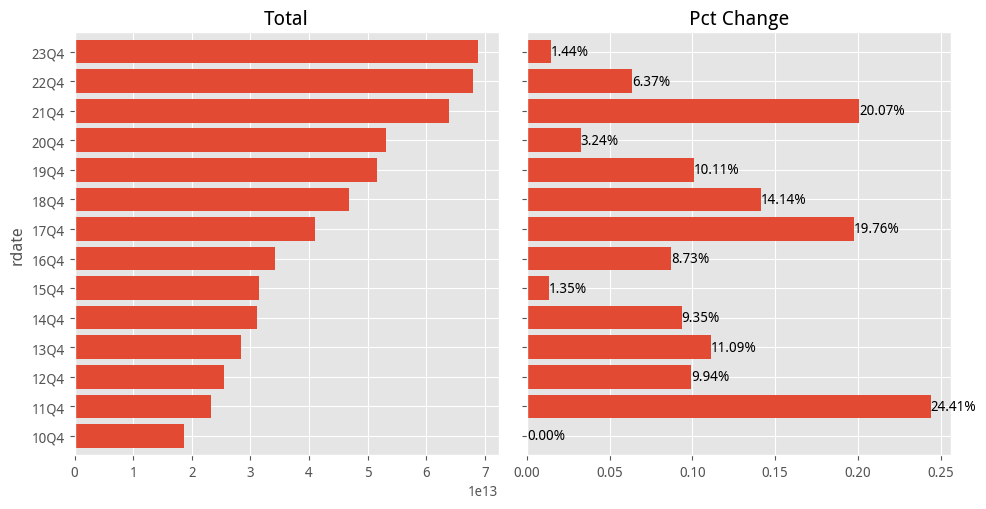

In [6]:
plot_total_change(revenue_df)

- 2023年收入仍保持增长，但处于历史低位。仅仅略高于2015年。
- 历史上的高位是2011年，2021年，和2017年。

In [7]:
yjbb.mostn_by_func(revenue_df, 20, ascending=False)

,sum,mean,median,min,max
0,中国石化,中国石化,中国石化,中国石化,中国石化
1,中国石油,中国石油,中国石油,中国石油,中国石油
2,中国建筑,中国建筑,中国建筑,中国中铁,中国建筑
3,中国中铁,中国中铁,中国平安,中国铁建,中国中铁
4,中国铁建,中国铁建,上汽集团,中国人寿,中国平安
5,中国平安,中国平安,工商银行,工商银行,中国铁建
6,工商银行,工商银行,中国中铁,中国建筑,工商银行
7,上汽集团,上汽集团,中国铁建,上汽集团,上汽集团
8,建设银行,建设银行,建设银行,建设银行,中国人寿
9,中国人寿,中国人寿,中国人寿,农业银行,建发股份


### 总体变化

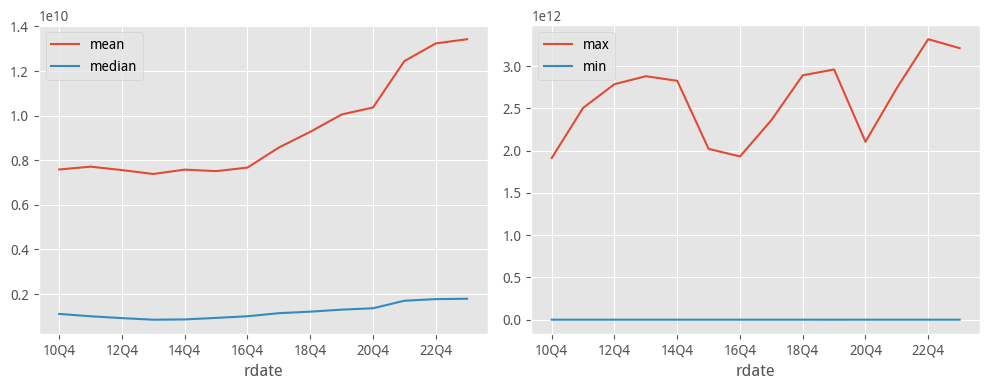

In [8]:
plot_desc(revenue_df)

- 均值和中位数整体趋势仍在增长。中位数增长更低，说明强者增长更大。
- 收入极值出现下降。

### 每年前20

In [9]:
top20 = yjbb.mostn_per_year(revenue_df.T, 20, ascending=False)
top20[1]

rdate,10Q4,11Q4,12Q4,13Q4,14Q4,15Q4,16Q4,17Q4,18Q4,19Q4,20Q4,21Q4,22Q4,23Q4
0,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化,中国石化
1,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油,中国石油
2,中国中铁,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑,中国建筑
3,中国铁建,工商银行,工商银行,工商银行,工商银行,工商银行,上汽集团,中国平安,中国平安,中国平安,中国平安,中国平安,中国中铁,中国中铁
4,中国人寿,中国中铁,中国铁建,中国铁建,上汽集团,上汽集团,中国平安,上汽集团,上汽集团,工商银行,中国中铁,中国中铁,中国铁建,中国铁建
5,工商银行,中国铁建,中国中铁,上汽集团,中国中铁,中国中铁,工商银行,工商银行,工商银行,中国中铁,中国铁建,中国铁建,中国平安,中国平安
6,中国建筑,上汽集团,上汽集团,中国中铁,中国铁建,中国平安,中国中铁,中国中铁,中国中铁,上汽集团,工商银行,工商银行,工商银行,工商银行
7,上汽集团,建设银行,建设银行,建设银行,建设银行,建设银行,中国铁建,中国铁建,中国铁建,中国铁建,中国人寿,中国人寿,建发股份,中国人寿
8,建设银行,中国人寿,农业银行,农业银行,农业银行,中国铁建,建设银行,中国人寿,建设银行,中国人寿,建设银行,建设银行,中国人寿,建设银行
9,农业银行,农业银行,中国人寿,中国人寿,中国平安,农业银行,中国人寿,建设银行,中国人寿,建设银行,上汽集团,上汽集团,建设银行,建发股份


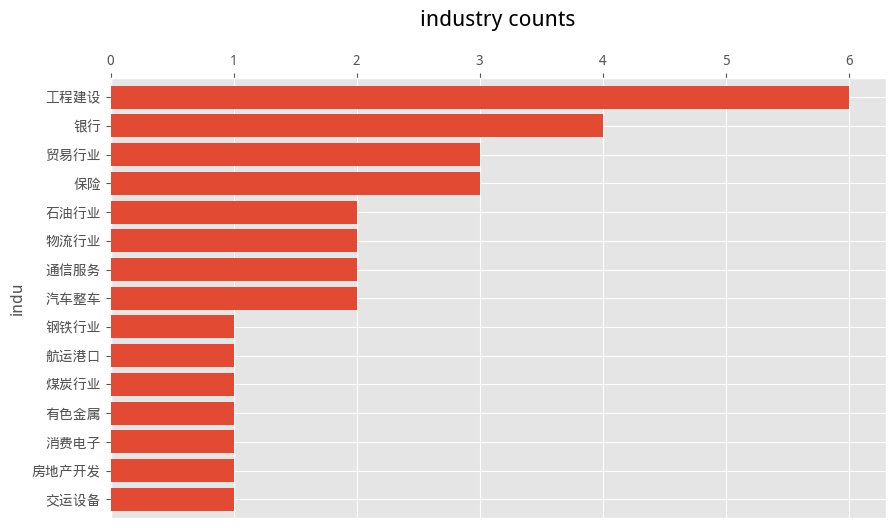

In [10]:
plot_barh(top20[0])

- 收入前两名已经固定了，一直是两桶油。第三名也基本固定，中国建筑。
- 第四名开始，有所变化，在各大金融机构之间轮换。中国铁建显示出优势。
- 从行业上来看，收入巨大的行业最多的是工程建设行业。中建，铁建，交建，电建

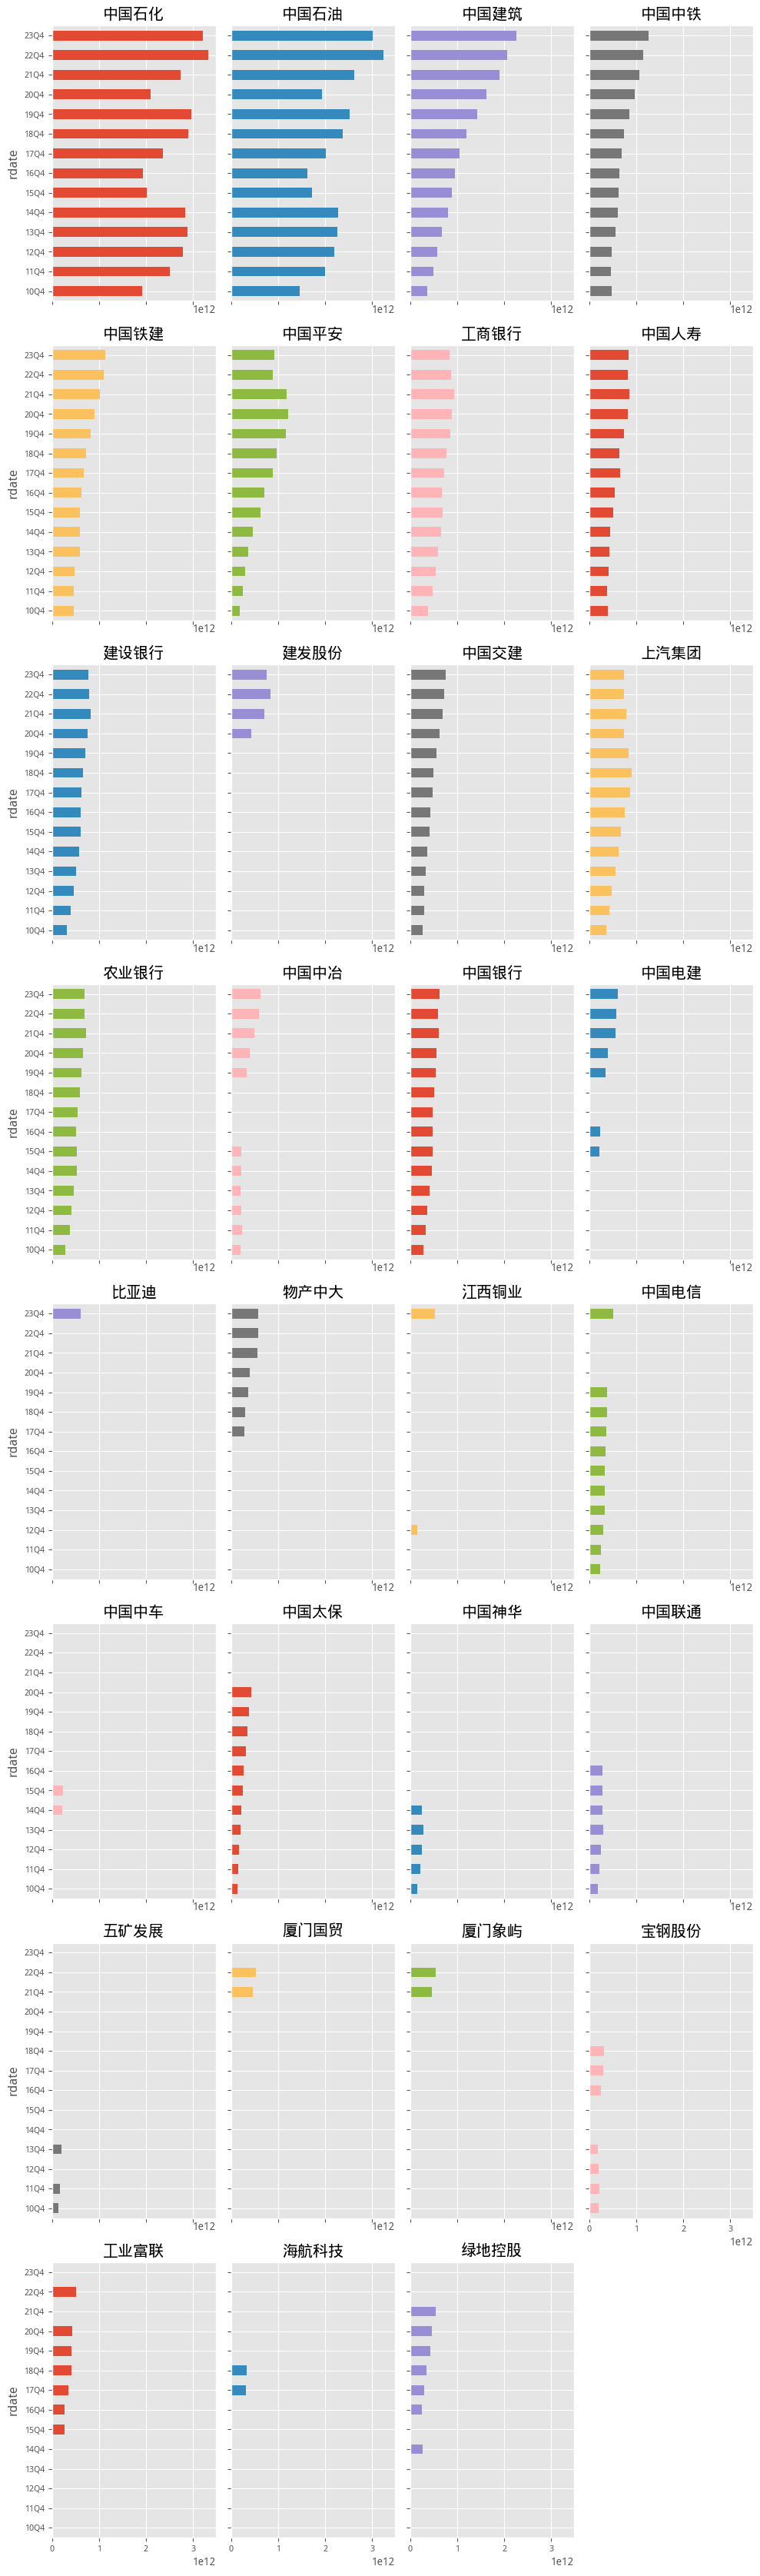

In [11]:
plot_subs(yjbb.get_topn(revenue_df,n=20)[0], 4)

- 所有曾上过前20榜的公司只有30家。能源排前列，其次是建筑和银行。
- 比亚迪首次入榜，当红小生。

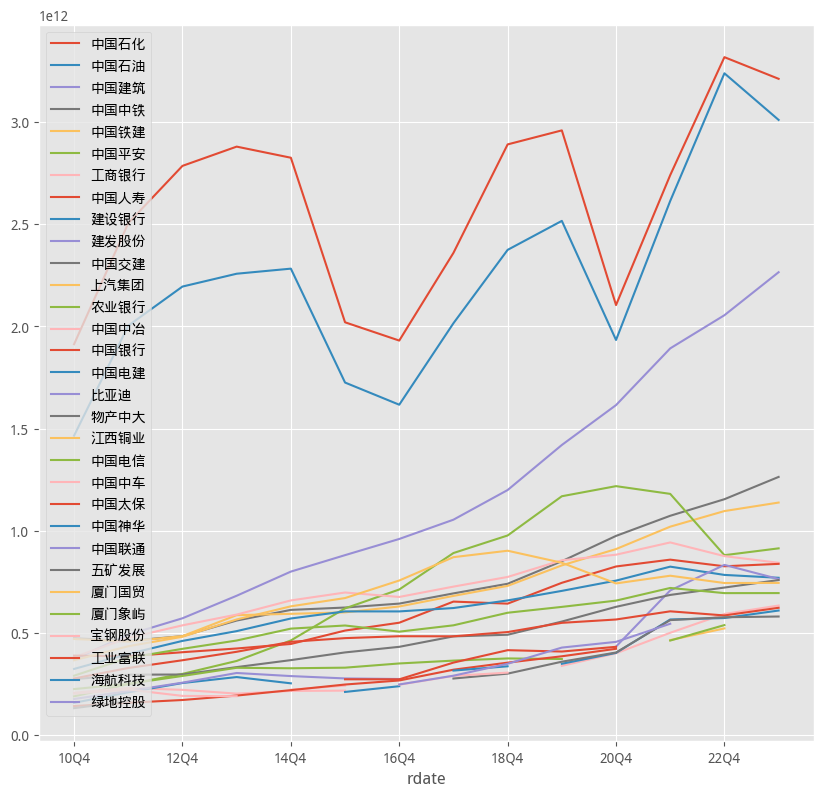

In [12]:
plot_muti_lines(yjbb.get_topn(revenue_df, 20)[0])

- 这些大巨头中，两桶油的波动相对较大，但地位无法动摇。
- 大金融中，平安的营收已经超过了工行，而且中国人寿和建设银行都相差不大了。

### 最近一年利润分布

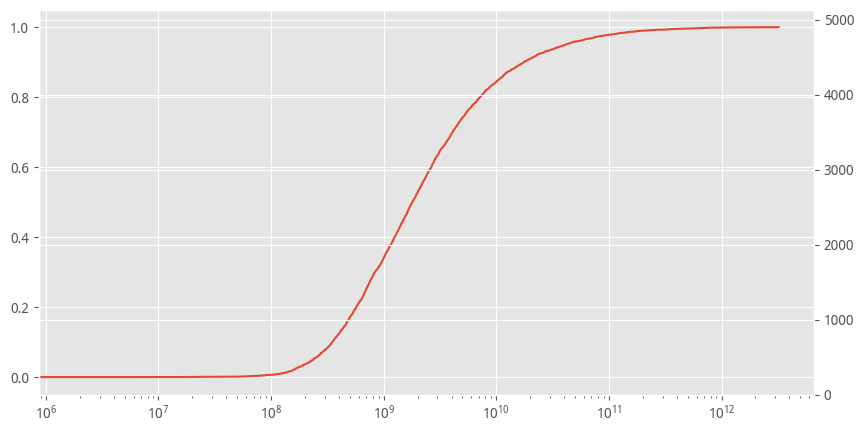

In [13]:
plot_cdf(revenue_df, logx=True)

- 2024年，有大约35%的公司超过10亿。
- 大约85%的公司在百亿级以下。

## TOP300

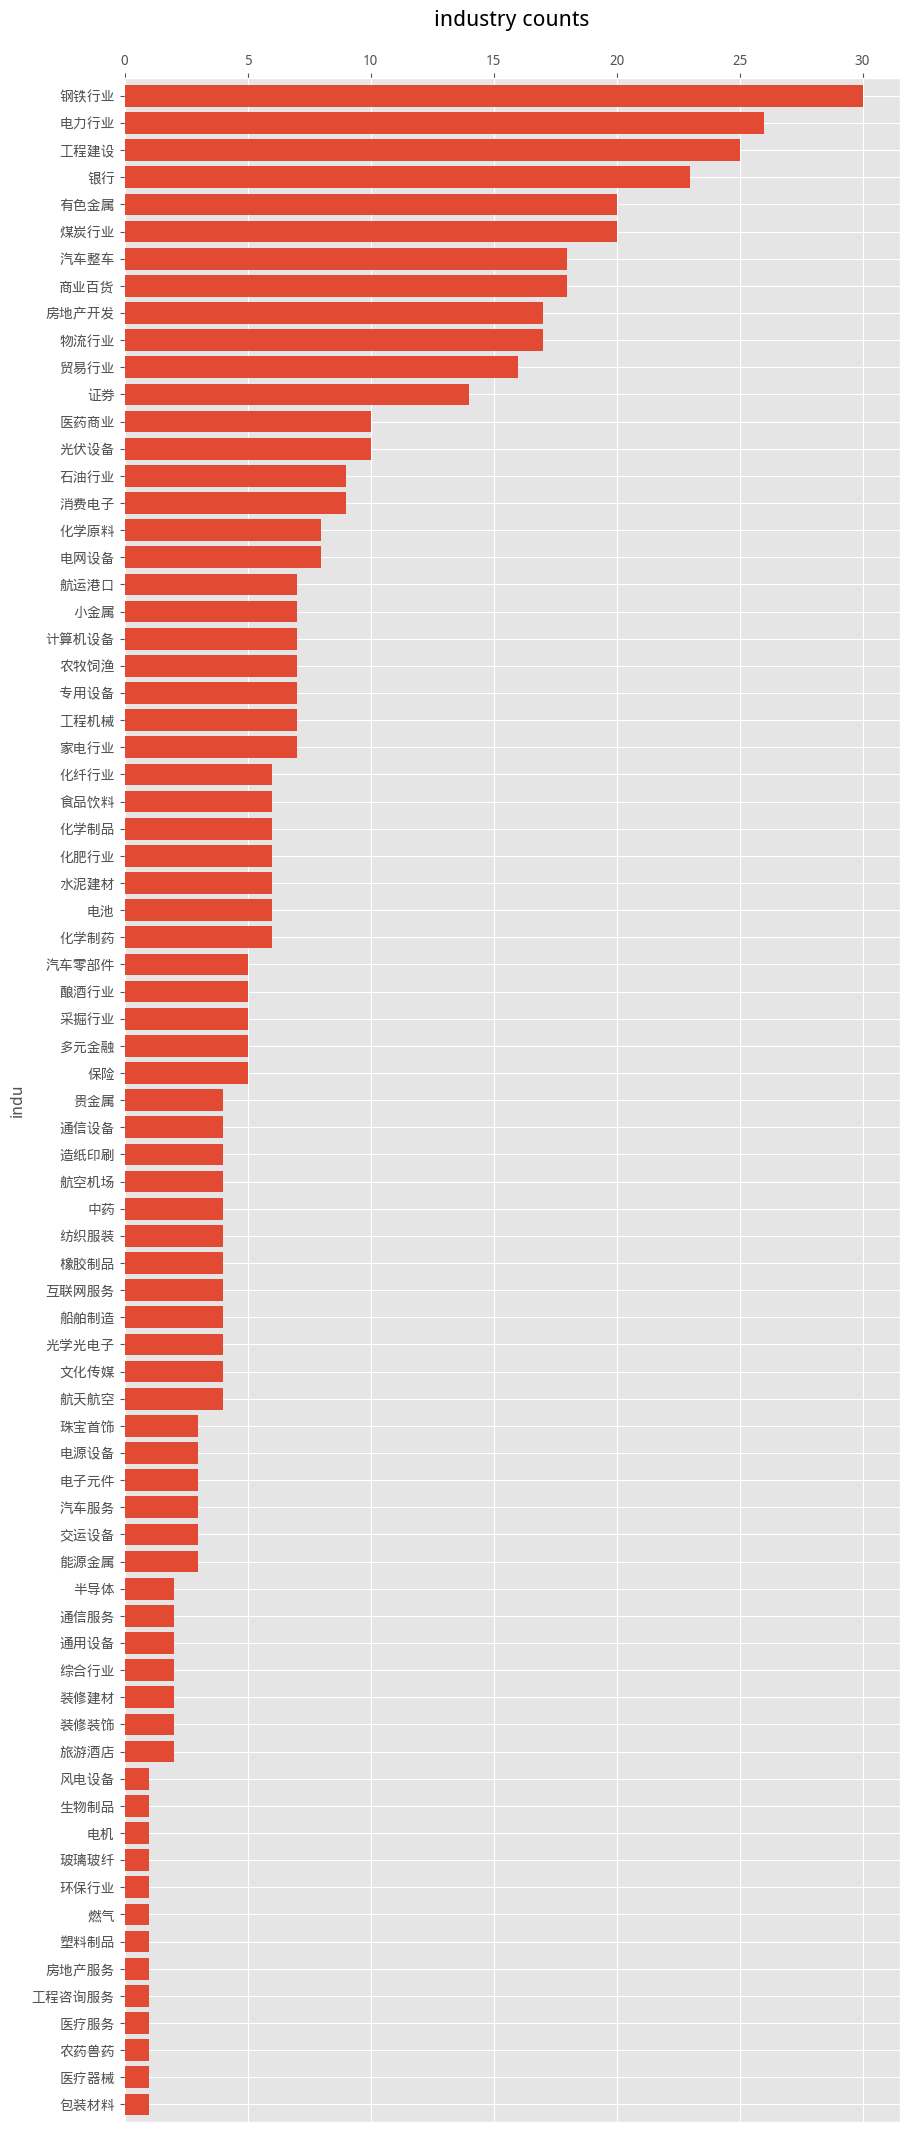

In [14]:
most300 = yjbb.mostn_per_year(revenue_df.T, 300)
plot_barh(most300[0])

- 收入高的行业集中在钢铁、电力、银行等。

In [15]:
top300 = yjbb.get_topn(revenue_df, 300)

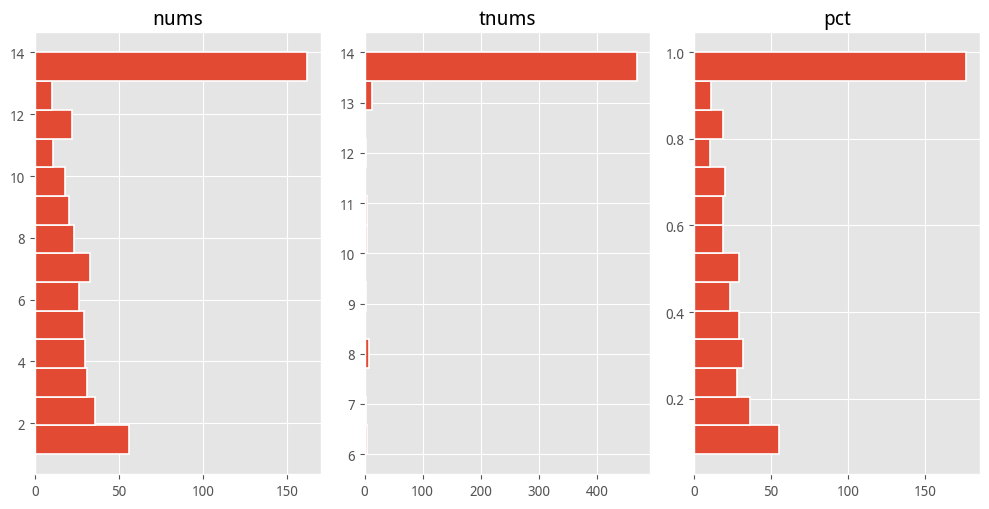

In [16]:
draw_vhists(top300[2].set_index('cname'))

- 超过150家公司长期上榜。
- 能上榜的公司都是成立比较早的公司。大多是在2010年以前成立的。

In [17]:
top162 = top300[2].sort_values(['pct','nums'], ascending=False).head(162).iloc[:,[0,1]]
plot_labs(top162, oneline=True)

- 上面是top300中，近14年全部入榜，或者仅仅错失一两次的名单。
- 计算了一下，其中银行或者商行为41家，占了总数的三分之一。
- 去掉大金融后，结果如下：

In [18]:
sel = top162[~top162['cname'].str.contains(r'银行|商行|证券|保险')]
print(f'大金融：{162-len(sel)} | 占比：{1-len(sel)/162}')
plot_labs(sel, oneline=True)

大金融：19 | 占比：0.11728395061728392


## 增长情况
- 选择了有6期以上报告的公司，测试其近5年利润增长的夏普指数平均值，从高到低排列。

In [19]:
incdf, sharpe = yjbb.incr_ana()

### 总体情况

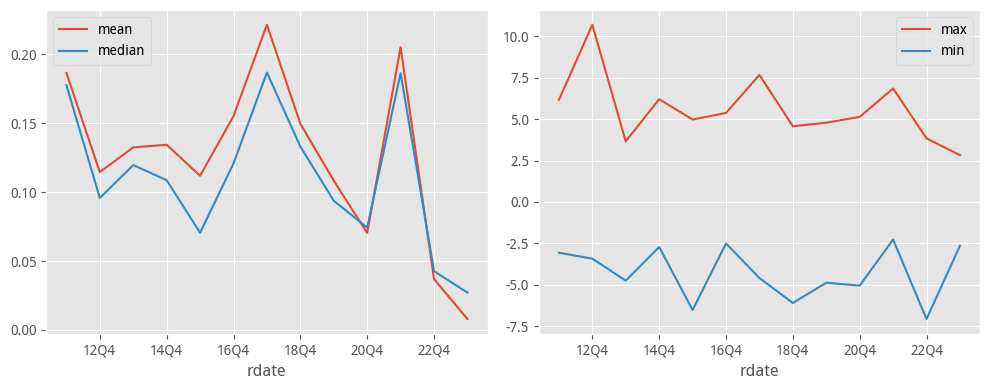

In [20]:
plot_desc(incdf)

- 增长下滑。均值和中位数都创历史新低。
- 极值缩小。

### 增长排名

In [21]:
test = yjbb.get_topn(incdf, 300)
test[2].head(20)

,cname,nums,tnums,pct
0,岩石股份,9,13,0.692308
1,复洁环保,6,10,0.600000
2,国联股份,6,11,0.545455
3,天下秀,6,13,0.461538
4,华海清科,6,6,1.000000
5,*ST中迪,6,13,0.461538
6,益生股份,6,13,0.461538
7,ST天龙,6,13,0.461538
8,长川科技,6,11,0.545455
9,明德生物,6,12,0.500000


- 国轩高科，好象在哪里见过。肯定不是一家好公司。
- 硅烷科技好象在几个榜单中都见过。可能是家好公司。
- 信达证券。大金融也能连续高增长，不多见。

### 最近一年增长情况

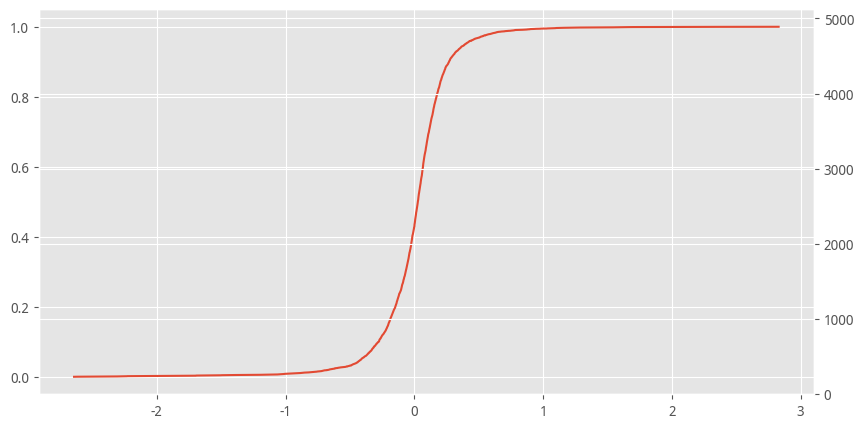

In [22]:
plot_cdf(incdf)

- 2023年，超过4成的上市公司没能实现营业收入增长。

### 夏普指数
- 夏普指数衡量增长的质量，比单纯看增长率要好一点。
- 以下是近五年夏普指数平均后的前300排名。

In [23]:
sharpe300 = sharpe.sort_values('sharpe_r5', ascending=False).head(300)[['cname', 'sharpe_r5']].head(300).reset_index(drop=True)
plot_labs(sharpe300, oneline=True)

## 利润金额和利润增长
- 利润总额曾经进入过前300,同时利润增长夏普指数近五年平均也进入前300
- 大金融不管怎么排，总能占到三分之一。

In [24]:
plot_labs(cross_dfs(sharpe.head(300), [top300[2]])[['cname', 'sharpe_r5', 'count']])

In [25]:
plot_labs(de_banks(cross_dfs(sharpe.head(300), [top300[2]])[['cname', 'sharpe_r5', 'count']]))

total: 28 | banks: 1 | non-banks: 27


In [28]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('03_yjbb_revenue.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()